# <img src="https://raw.githubusercontent.com/alsinmr/SLEEPY_tutorial/033b817f027ebdcd6493a1f42ab9fdec290dbee8/JupyterBook/favicon.png"  width=40> <font  color = "#0093AF">Exchange Spectroscopy (EXSY)</font>

In the previous example, we simulated exchange in a 1D spectrum. Here, we perform the 2D EXSY experiment. We will then calculate the 2D EXSY spectrum, and observe how that spectrum changes as a function of a mixing time. We will also investigate the 2D spectrum as a function of correlation time of exchange.

## Setup

In [0]:
# SETUP SLEEPY
!pip install -i https://test.pypi.org/simple/ sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system
The first step is to build the systems (`ex0`,`ex1`), which will have a single nucleus, with two different chemical shifts.

In [3]:
ex0=sl.ExpSys(Nucs='13C',v0H=600)    #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=-5)   #Add the chemical shifts
_=ex1.set_inter(Type='CS',i=0,ppm=5)

## Add the exchange process
First, we export the systems into Liouville space, and add the exchange process. We also add some $T_2$ relaxation to destroy transverse magnetization during the delay period for exchange and produce some broadening when the spectrum is very narrow (`L.add_relax(...)`).

In [4]:
L=sl.Liouvillian(ex0,ex1)           #Builds the two different Hamiltonians and exports them to Liouville space

tc=1     #Correlation time (1 s)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)

_=L.add_relax(Type='T2',i=0,T2=.01)

## Run as a 2D experiment
First, we'll just calculate one 2D spectrum, and then later check how the spectrum evolves as a function of a delay time. We need an initial density matrix, $S_x$, a detection matrix, $S^+$, and propagators for evolution times, $\pi$/2 pulses, and a delay for the exchange process. We start with generating the propagators and density matrices.

SLEEPY has a function in `sl.Tools`, `sl.Tools.TwoD_Builder`, for executing and processing two-dimensional experiements. `TwoD_Builder` requires an initial density matrix (`rho`), and sequences for the indirect dimension evolution, the direction dimension evolution (in this example, `seq` is used for both), and transfer periods between the dimensions (`seq_trX`, `seq_trY`). For the transfers, one needs a sequence to convert the X component, and one for the Y component (States acquisition$^1$). The sequences for the direct/indirect dimension may just be delays, and can be the same sequence.

[1] D.J. States, R.A. Haberkorn, D.J. Ruben. [*J. Magn. Reson.*](https://doi.org/10.1016/0022-2364(82)90279-7), **1969**, 48, 286-292.

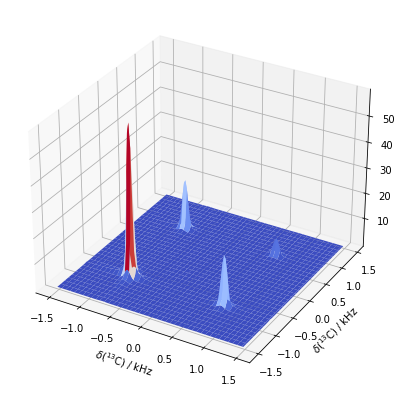

In [5]:
rho=sl.Rho(rho0='S0x',detect='S0p')
# L.Udelta('13C',np.pi/2,np.pi/2)*rho

Dt=1/(2*10*150)  #Delay for a spectrum about twice as broad as the chemical shift difference
seq=L.Sequence(Dt=Dt)  #Sequence for indirect and direct dimensions
seq_trX=L.Sequence()  #X-component of transfer
seq_trY=L.Sequence()  #Y-component of transfer

v1=50000     #pi/2 pulse field strength
tpi2=1/v1/4  #pi/2 pulse length
dly=5
t=[0,tpi2,dly,dly+tpi2] #pi/2 pulse, 1 second delay, pi/2 pulse
seq_trX.add_channel('13C',t=t,v1=[v1,0,v1],phase=[-np.pi/2,0,np.pi/2]) #Convert x to z, delay, convert z to x
seq_trY.add_channel('13C',t=t,v1=[v1,0,v1],phase=[0,0,np.pi/2]) #Convert y to z, delay, convert z to x

twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
twoD(32,64)

ax=twoD.plot()
ax.set_xlabel(r'$\delta$($^{13}$C) / kHz')
_=ax.set_ylabel(r'$\delta$($^{13}$C) / kHz')
ax.figure.set_size_inches([7,7])

## Sweep the delay time to observe buildup
In order to observe the diagonal peaks decay, and the off-diagonal peaks build up, we repeat the above calculation except with different lengths for the delay. We slice through the largest peak and observe buildup of the cross-peak at the same position.

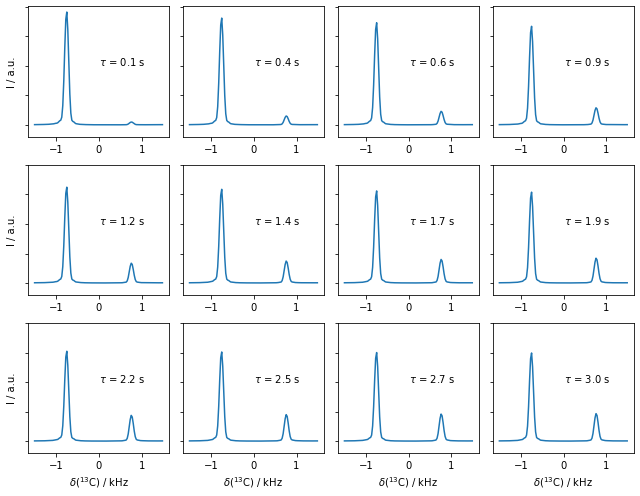

In [6]:
i_dir=[16,48]
i_in=[32,96]

delays=np.linspace(0.1,3,12)
fig,ax=plt.subplots(3,4,figsize=[9,7])
ax=ax.flatten()
I=list()
sm=0
for a,delay in zip(ax,delays):
    t=[0,tpi2,delay,delay+tpi2] #pi/2 pulse, 1 second delay, pi/2 pulse
    seq_trX.clear()
    seq_trY.clear()
    seq_trX.add_channel('13C',t=t,v1=[v1,0,v1],phase=[-np.pi/2,0,np.pi/2]) #Convert x to z, delay, convert z to x
    seq_trY.add_channel('13C',t=t,v1=[v1,0,v1],phase=[0,0,np.pi/2]) #Convert y to z, delay, convert z to x

    twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
    twoD(32,64).proc()
    
    a.plot(twoD.v_in/1e3,twoD.Sreal[i_dir[0]].real)
    sm=max(a.get_ylim()[1],sm)
    
    I.append([twoD.Sreal[i_dir[0],i_in[0]].real,twoD.Sreal[i_dir[1],i_in[1]].real,
             twoD.Sreal[i_dir[0],i_in[1]].real,twoD.Sreal[i_dir[1],i_in[0]].real])

I=np.array(I)

for a,delay in zip(ax,delays):
    a.set_ylim([-sm*.1,sm])
    a.text(0,sm*.5,r'$\tau$'+f' = {delay:.1f} s')
    a.set_yticklabels('')
    if a.is_last_row():
        a.set_xlabel(r'$\delta$($^{13}$C) / kHz')
    if a.is_first_col():
        a.set_ylabel('I / a.u.')
        
fig.tight_layout()

## Plot trajectory of the individual peaks
We can track the four peak intensities as a function of delay time. Then, each curve represents the probability of starting in some state and ending in another state after the delay time, $\tau$. These are given in the legend, where the diagonal peaks then decay with time and the cross peaks build up.

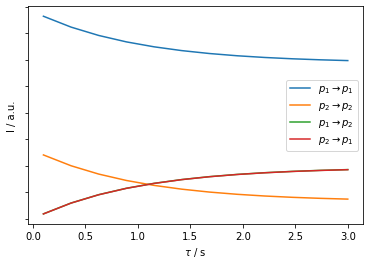

In [8]:
I=np.array(I)

ax=plt.subplots()[1]
ax.plot(delays,I)
ax.set_xlabel(r'$\tau$ / s')
ax.set_ylabel('I / a.u.')
ax.set_yticklabels('')
_=ax.legend((r'$p_1\rightarrow p_1$',r'$p_2\rightarrow p_2$',r'$p_1\rightarrow p_2$',r'$p_2\rightarrow p_1$'))

## Spectrum as a function of exchange rate
We can't use EXSY for very fast motions, because the peaks coalesce such that we are no longer able to observe the independent buildup of the cross peaks. Here, we simulate the coalescence of the four peaks by varying the correlation time.

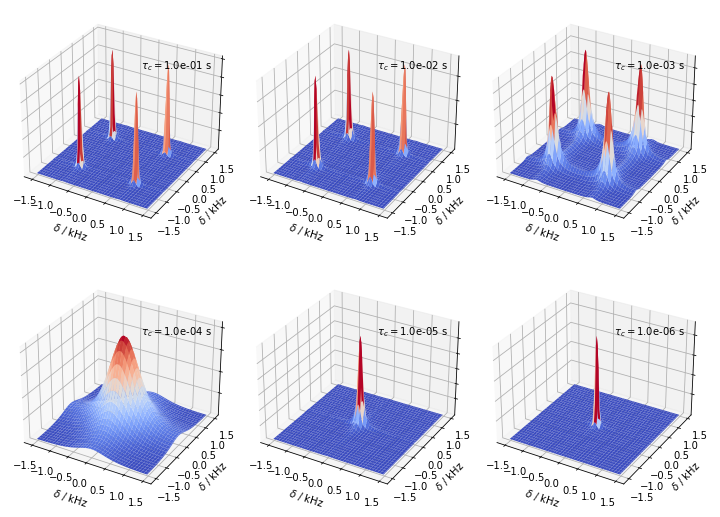

In [9]:
tc0=np.logspace(-1,-6,6)
p1=0.5  #Population of state 1
p2=1-p1  #Population of state 2

fig=plt.figure(figsize=[10,8])
ax=[fig.add_subplot(2,3,k+1,projection='3d') for k in range(6)]
for a,tc in zip(ax,tc0):
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
    twoD(32,64).proc()
    
    #Plot the result
    twoD.plot(ax=a)
    a.text(1,-1,a.get_zlim()[1]*1.3,r'$\tau_c = $'+f'{tc:.1e} s')
    
fig.tight_layout()
for a in ax:a.set_zticklabels('')

Finally, we do the same as above, but without having symmetric exchange, i.e. $p_1\ne p_2$. Here, we set $p_1=0.75$ and $p_2=0.25$. We use the `sl.Tools.twoSite_kex(tc=...,p1=...)` function to build the exchange matrix.

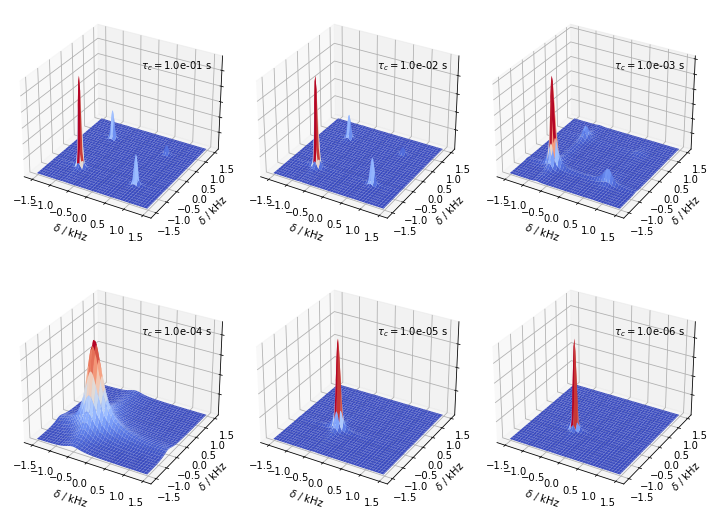

In [10]:
tc0=np.logspace(-1,-6,6)
p1=0.75  #Population of state 1
p2=1-p1  #Population of state 2

fig=plt.figure(figsize=[10,8])
ax=[fig.add_subplot(2,3,k+1,projection='3d') for k in range(6)]
for a,tc in zip(ax,tc0):
    L.kex=sl.Tools.twoSite_kex(tc=tc,p1=p1)
    
    twoD=sl.Tools.TwoD_Builder(rho,seq_dir=seq,seq_in=seq,seq_trX=seq_trX,seq_trY=seq_trY)
    twoD(32,64).proc()
    
    #Plot the result
    twoD.plot(ax=a)
    a.text(1,-1,a.get_zlim()[1]*1.3,r'$\tau_c = $'+f'{tc:.1e} s')
    
fig.tight_layout()
for a in ax:a.set_zticklabels('')

## Explicit execution and processing of the 2D sequence
Above, we have used a built-in class for executing and processing 2D spectra in SLEEPY, however, it may be informative to once execute the whole processing manually.

### Acquisition

In [11]:
# Start from L that has already been generated
L.kex=sl.Tools.twoSite_kex(tc=1,p1=0.75)

rho=sl.Rho(rho0='S0x',detect='S0p')

Uevol=seq.U()

RE=list()
IM=list()
n=64
for k in range(n):
    #First capture the real part
    rho.clear()  #Clear all data in rho
    Uevol**k*rho  #This applies the evolution operator k times
    seq_trX*rho
    rho.DetProp(Uevol,n=n)
    RE.append(rho.I[0])
    
    #Then capture the imaginary part
    rho.clear()  #Clear all data in rho
    Uevol**k*rho  #This applies the evolution operator k times
    seq_trY*rho
    rho.DetProp(Uevol,n=n)
    IM.append(rho.I[0])

### Processing

In [12]:
RE,IM=np.array(RE,dtype=complex),np.array(IM,dtype=complex) #Turn lists into arrays
# Divide first time points by zero
RE[:,0]/=2
RE[0,:]/=2
IM[:,0]/=2
IM[0,:]/=2
# QSINE apodization function
apod=np.cos(np.linspace(0,1,RE.shape[0])*np.pi/2)**2
RE=RE*apod
RE=(RE.T*apod).T
IM=IM*apod
IM=(IM.T*apod).T

nft=n*2
FT_RE=np.fft.fft(RE,n=nft,axis=1).real.astype(complex)
FT_IM=np.fft.fft(IM,n=nft,axis=1).real.astype(complex)
spec=np.fft.fftshift(np.fft.fft(FT_RE+1j*FT_IM,n=nft,axis=0),axes=[0,1])
v=1/(2*Dt)*np.linspace(-1,1,spec.shape[0])  #Frequency axis
v-=(v[1]-v[0])/2 #Shift to have zero at correct position
v*=1e6/ex0.v0[0]   #convert to ppm
vx,vy=np.meshgrid(v,v)  #meshgrid for plotting

### Plotting

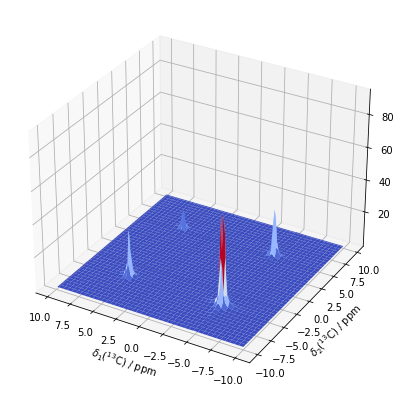

In [17]:
from matplotlib import cm
fig=plt.figure(figsize=[7,7])
ax=fig.add_subplot(111,projection='3d')
ax.plot_surface(vx,vy,spec.real,cmap='coolwarm',linewidth=0)
ax.set_xlabel(r'$\delta_1 (^{13}$C) / ppm')
ax.set_ylabel(r'$\delta_2 (^{13}$C) / ppm')
ax.invert_xaxis()
ax.invert_yaxis()